In [1]:
import numpy as np
from astropy.time import Time

from mpcq.client import MPCObservationsClient
from mpcq.utils import observations_to_dataframe, submissions_to_dataframe

client = MPCObservationsClient.connect_using_gcloud()

This notebook requires `find_orb` to be installed. `find_orb` is a C/C++ code written by Bill Gray, that calculates an orbit given observations. Its a community favorite and in use by surveys like the Catalina Sky Survey. By default, find_orb will install its executables inside of ~/bin. 

See this [Dockerfile](https://github.com/Bill-Gray/find_orb/blob/master/Dockerfile) for instructions on how to install find_orb. 

In [2]:
object_id = "2012 DA14"

# Query for this object's observations and its submission history
# We will use the submission history to determine the order in which
# observations for this object were found and submitted to the MPC
observations = client.get_object_observations(object_id)
submissions = client.get_object_submissions(object_id)

observations = observations_to_dataframe(list(observations))
observations.sort_values(by="timestamp", inplace=True, ignore_index=True)

submissions = submissions_to_dataframe(list(submissions))
submissions.sort_values(by="timestamp", inplace=True, ignore_index=True)

In [3]:
submissions

,id,num_observations,timestamp
0,2012-02-23T01:48:30.001_00005I8W,3,2012-02-23 01:48:30.001
1,2012-02-23T01:59:46.000_00005I8e,3,2012-02-23 01:59:46.000
2,2012-02-23T02:31:28.000_00005I96,3,2012-02-23 02:31:28.000
3,2012-02-23T03:05:24.001_00005I9T,4,2012-02-23 03:05:24.001
4,2012-02-23T07:35:57.001_00005ICj,3,2012-02-23 07:35:57.001
...,...,...,...
112,2013-02-25T12:57:28.001_00005UZp,45,2013-02-25 12:57:28.001
113,2013-05-13T11:02:33.001_00004TDN,26,2013-05-13 11:02:33.001
114,2013-05-13T21:14:46.001_00004TLN,47,2013-05-13 21:14:46.001
115,2013-05-21T15:37:35.001_00004Vlu,11,2013-05-21 15:37:35.001


In [4]:
import subprocess
import os
import tempfile
import json
import shutil
import uuid
import quivr as qv

from adam_core.orbits import Orbits
from adam_core.coordinates import CartesianCoordinates, CoordinateCovariances, Origin
from adam_core.time import Timestamp


class FittedOrbits(qv.Table):
    orbit_id = qv.LargeStringColumn(default= lambda: str(uuid.uuid4()))
    object_id = qv.LargeStringColumn()
    coordinates = CartesianCoordinates.as_column()
    included_observations = qv.Int64Column()
    rejected_observations = qv.Int64Column()
    arc_length = qv.Float64Column()

    def to_orbits(self) -> Orbits:
        return Orbits.from_kwargs(
            orbit_id=self.orbit_id,
            object_id=self.object_id,
            coordinates=self.coordinates,
        )

def observations_to_ades(observations, file_out) -> str:
    """
    Writes observations to a reduced MPC ADES file that can be 
    used with find_orb. 

    """
    ades = observations.rename(columns={
        "unpacked_provisional_designation": "provID",
        "timestamp": "obsTime",
        "ra_rms": "rmsRA",
        "dec_rms": "rmsDec",
        "mag_rms": "rmsMag",
        "filter_band": "band",
        "obscode": "stn",
    })

    column_order = ["provID", "obsTime", "ra", "dec", "mag", "rmsRA", "rmsDec", "rmsMag", "band", "stn"]
    ades = ades[column_order]

    observation_times = Time(
        ades["obsTime"].values,
        format="datetime64",
        scale="utc",
        precision=3,
    )
    ades["obsTime"] = np.array([i + "Z" for i in observation_times.utc.isot])

    # Note not necessarily true for all observations 
    ades["astCat"] = np.full(len(ades), "Gaia2")
    ades["mode"] = np.full(len(ades), "CCD")

    col_header = "|".join(ades.columns) + "\n"

    with open(file_out, "w") as f:
        f.write("# version=2017\n")
        f.write(col_header)

    return ades.to_csv(file_out, index=False, header=False, sep="|", mode="a")

def run_find_orb(observations, out_dir=None):
    """
    Runs find_orb on the given observations and returns the calculated
    orbit and covariance matrix. 

    """
    assert observations["unpacked_provisional_designation"].nunique() == 1

    my_env = os.environ.copy()
    my_env["PATH"] = f"{os.path.expanduser('~/bin')}:{my_env['PATH']}"

    with tempfile.TemporaryDirectory() as tempdir:
        ades_file = os.path.join(tempdir, "ades.psv")
        observations_to_ades(observations, ades_file)

        output = subprocess.run(
            ["fo", ades_file, "-O", tempdir, f"-tEjd{Time(observations['timestamp'].max(), scale='utc').utc.jd}", "-j"],
            capture_output=True,
            text=True,
            env=my_env,
        )

        if output.returncode != 0:
            raise RuntimeError(f"find_orb failed: {output.stderr}")
        
        # Read orbit and covariance from covar.json
        try:
            with open(os.path.join(tempdir, "covar.json")) as f:
                result = json.load(f)
                
                state = np.array(result["state_vect"])
                covariance_matrix = np.array(result["covar"]).reshape(1, 6, 6)
                coords = CartesianCoordinates.from_kwargs(
                    time=Timestamp.from_jd([result["epoch"]], scale="tt"),
                    x=state[0:1],
                    y=state[1:2],
                    z=state[2:3],
                    vx=state[3:4],
                    vy=state[4:5],
                    vz=state[5:],
                    covariance=CoordinateCovariances.from_matrix(covariance_matrix),
                    origin=Origin.from_kwargs(code=["SUN"]),
                    frame="ecliptic",
                )
        
        except FileNotFoundError:
            return FittedOrbits.empty()

        # Read information about the observations used from total.json
        with open(os.path.join(tempdir, "total.json")) as f:
            result_total = json.load(f)

            object_id = observations["unpacked_provisional_designation"].values[0]
            included_observations = result_total["objects"][object_id]["observations"]["used"]
            rejected_observations = result_total["objects"][object_id]["observations"]["count"] - included_observations
            arc_length = result_total["objects"][object_id]["observations"]["latest_used"] - result_total["objects"][object_id]["observations"]["earliest_used"]

        if out_dir is not None:
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            shutil.copytree(tempdir, out_dir)
            shutil.copy(ades_file, out_dir)
        
    return FittedOrbits.from_kwargs(
        object_id=observations["unpacked_provisional_designation"].values[:1], 
        coordinates=coords,
        included_observations=[included_observations],
        rejected_observations=[rejected_observations],
        arc_length=[arc_length],
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
def run_object_observations_by_submission(observations, submissions):
    """
    Runs find_orb on the observations for a given object, grouped by
    submission. 

    """
    fitted_orbits = []
    submission_ids = []
    last_submission = []
    unique_submission_ids = submissions["id"].unique()
    for submission_id in unique_submission_ids:
        submission_ids.append(submission_id)
        observations_subset = observations[observations["submission_id"].isin(submission_ids)]
        fitted_orbits_i = run_find_orb(observations_subset)
        if len(fitted_orbits_i) > 0:
            fitted_orbits.append(fitted_orbits_i)
            last_submission.append(submission_id)
        else:
            print(f"Orbit fit for submissions up to {submission_id} failed.")

    return last_submission, qv.concatenate(fitted_orbits)

submission_ids, orbits = run_object_observations_by_submission(observations, submissions)

In [6]:
orbits.to_dataframe()

,orbit_id,object_id,coordinates.x,coordinates.y,coordinates.z,coordinates.vx,coordinates.vy,coordinates.vz,coordinates.time.days,coordinates.time.nanos,coordinates.covariance.values,coordinates.origin.code,included_observations,rejected_observations,arc_length
0,b768c790-d6bb-4c58-9f9b-64c07ed9cb1e,2012 DA14,-1.185593,0.317395,0.405326,0.046416,0.035499,-0.042652,55980,3030652803183,"[79.8770046299, 32.5378910486, -108.236433025,...",SUN,3,0,0.013021
1,b69dc5bc-07ca-4070-aa2a-6236624485a0,2012 DA14,-0.924449,0.423694,0.051424,0.010655,-0.004358,-0.021183,55980,4459190417826,"[2.18073505887e-05, 8.85841323419e-06, -2.9575...",SUN,4,2,0.046088
2,09415be3-f347-42d6-9e49-fc2b6f2828b6,2012 DA14,-0.903583,0.432002,0.022986,-0.008633,-0.014276,0.002786,55980,5817225618660,"[1.09816335439e-06, 4.44415914565e-07, -1.4911...",SUN,6,3,0.064514
3,f2ec9028-2cd3-41a2-94fd-3f59d263e110,2012 DA14,-0.903539,0.431875,0.022807,-0.008638,-0.014297,0.002780,55980,6975158384442,"[1.83186139874e-08, 7.38833060396e-09, -2.4898...",SUN,10,3,0.091319
4,28ef6bcb-a906-42e4-a0a5-591b54d7bab7,2012 DA14,-0.904274,0.430571,0.022972,-0.008804,-0.014395,0.003030,55980,15015196810663,"[2.58470330545e-09, 1.02115307966e-09, -3.5397...",SUN,14,2,0.277431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,8fa856f6-1149-4f15-8fec-25504aca6b87,2012 DA14,0.642319,-0.800302,0.059431,0.011801,0.011512,-0.002930,56161,37197187216580,"[6.77248004222e-14, 6.34601596733e-14, -3.1980...",SUN,944,38,362.790891
113,5c4ad255-e598-4d51-a225-b98b92e23a9a,2012 DA14,0.642320,-0.800302,0.059431,0.011801,0.011512,-0.002930,56161,37197187216580,"[6.68760214586e-14, 6.26570800299e-14, -3.1600...",SUN,963,45,362.790891
114,63c3df4f-1e9e-4e7e-95b8-cc4fb512eca2,2012 DA14,0.642319,-0.800302,0.059431,0.011801,0.011512,-0.002930,56161,37197187216580,"[6.67131337075e-14, 6.25098161865e-14, -3.1520...",SUN,964,91,362.790891
115,ffdfa853-c808-414e-8939-4809079c5398,2012 DA14,0.635154,-0.807021,0.062853,0.011870,0.011400,-0.003004,56161,37197187216580,"[1.44071212776e-05, 1.32518467766e-05, -7.3483...",SUN,980,86,362.790891


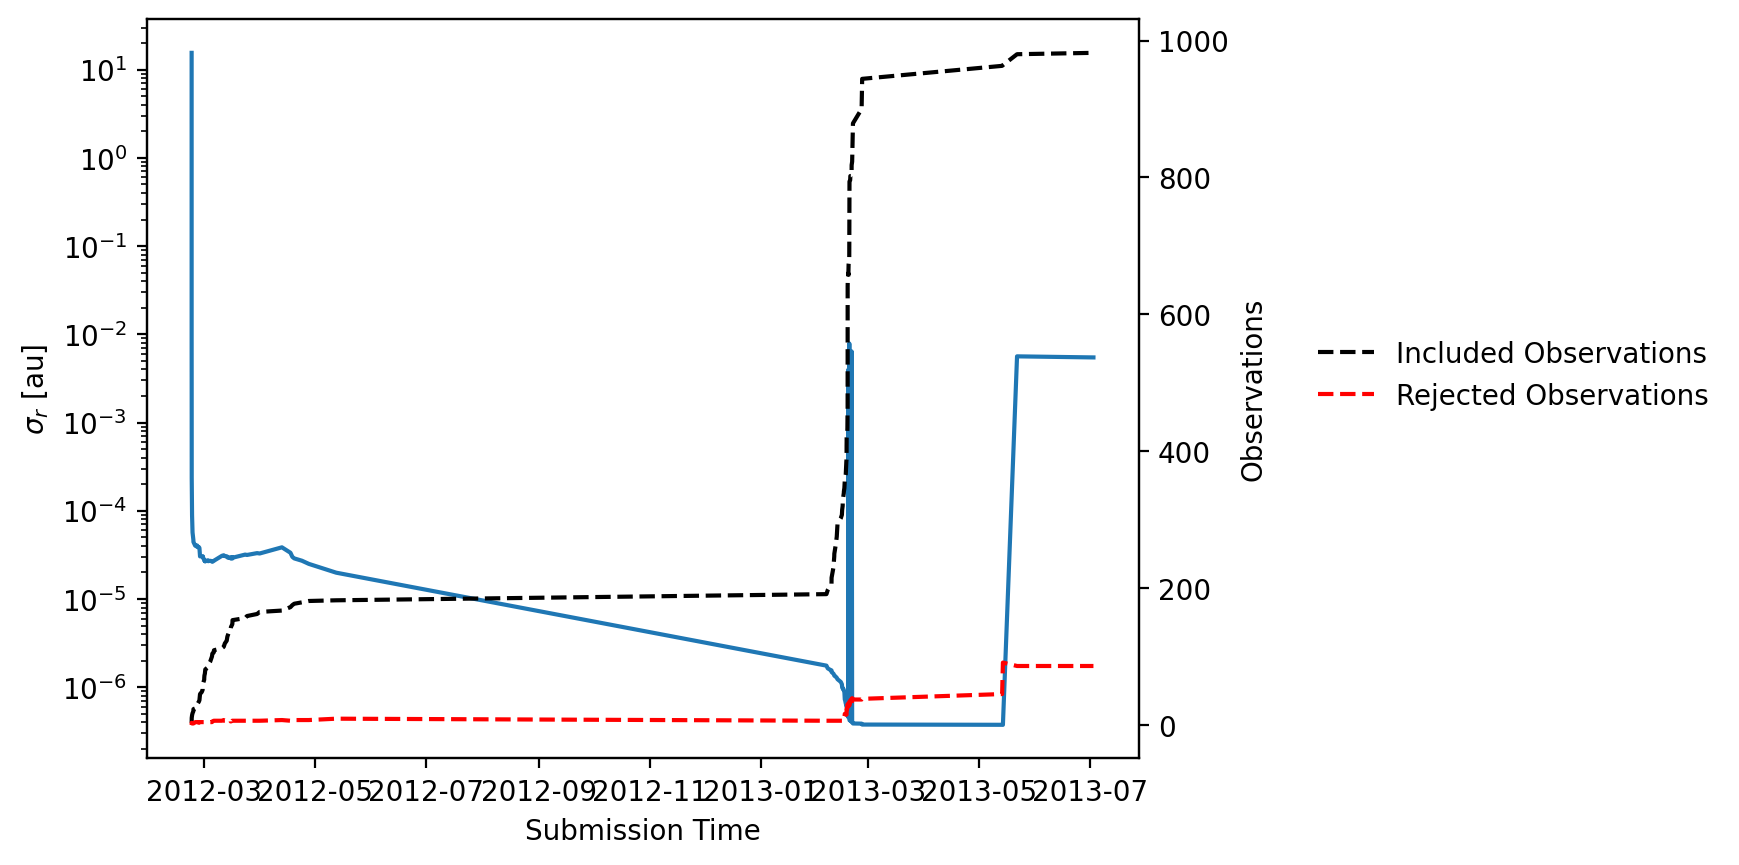

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(submissions[submissions["id"].isin(submission_ids)]["timestamp"], orbits.coordinates.sigma_r_mag)
ax.set_yscale("log")
ax.set_ylabel(r"$\sigma_r$ [au]")
ax.set_xlabel("Submission Time")

ax2 = ax.twinx()
ax2.plot(
    submissions[submissions["id"].isin(submission_ids)]["timestamp"], 
    orbits.included_observations, 
    c="k", 
    ls="--",
    label="Included Observations"
)
ax2.plot(
    submissions[submissions["id"].isin(submission_ids)]["timestamp"], 
    orbits.rejected_observations, 
    c="r", 
    ls="--",
    label="Rejected Observations"
)
ax2.set_ylabel("Observations")
ax2.legend(frameon=False, bbox_to_anchor=(1.6, 0.6))